In [1]:
from astropy import units as u
from astropy import time
import astropy
import numpy as np

from poliastro import iod
from poliastro.bodies import Body,Mars, Earth, Venus, Jupiter, Saturn, Uranus, Neptune, Sun, Europa, Ganymede, Callisto, Io, Titan
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
import math
import matplotlib.pyplot as plt
# More info: https://plotly.com/python/renderers/
import plotly.io as pio
from poliastro.util import norm, time_range
pio.renderers.default = "plotly_mimetype+notebook_connected"

from astropy.coordinates import solar_system_ephemeris


solar_system_ephemeris.set("jpl")

<ScienceState solar_system_ephemeris: 'jpl'>

In [11]:
start_date = time.Time("2037-07-18 01:01", scale="utc").tdb
end_date = time.Time("2037-07-25 01:01", scale="utc").tdb

epoch=time_range(start=start_date, end=end_date)

io_ephem = Ephem.from_horizons(501,epochs= epoch, attractor= Jupiter)#Io is 501
ganymede_ephem = Ephem.from_horizons(503,epochs= epoch, attractor= Jupiter)#Ganymede is 503
europa_ephem = Ephem.from_horizons(502,epochs= epoch, attractor= Jupiter)#Europa is 592
callisto_ephem = Ephem.from_horizons(504,epochs= epoch, attractor= Jupiter)

orb_europa = Orbit.from_ephem(Jupiter, europa_ephem, start_date)
orb_callisto = Orbit.from_ephem(Jupiter, callisto_ephem, start_date)
orb_io = Orbit.from_ephem(Jupiter, io_ephem, start_date)
orb_ganymede = Orbit.from_ephem(Jupiter, ganymede_ephem, start_date)

#we will take 250km as periapsis
r_p = Jupiter.R + 250 * u.km

a_final_europa = (orb_europa.a + (Jupiter.R + 250 * u.km)) / 2
a_final_ganymede = (orb_ganymede.a + (Jupiter.R + 250 * u.km)) / 2  





/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "utctai" yielded 1 of "dubious year (Note 3)"

/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning:

ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"



Using the visa-viva, we can naivily calculate how long it'll take to get to get the apijove of our orbit down to either Ganymede or Europa only. We can work out the semi major axis (A) of an orbit with a perijove barely inside the Jovian atmosphere and apijove just outside Ganymede:
$$
T=2\pi \sqrt{\frac{A^3}{\mu}},\quad V_{pj}=\sqrt{\mu(\frac{2}{r}-\frac{1}{a})}
$$

In [76]:
#change in period of orbit for a given change in velocity and initial orbit period, assuming the same perijove altitude
# print(Jupiter.k)
print(f"Periapsis altitude is {r_p.to(u.km)}")
def deltaT(Ti,deltaV):
    Ai = (((Ti/(2*math.pi))**2) * Jupiter.k)**(1/3)
    # print(Ai.si)
    Vi = (Jupiter.k * (-1/(Ai.si) + 2/r_p))**0.5
    # print(Vi)
    Vf = Vi - deltaV 
    # print(Vf)
    Af = -((Vf**2)/(Jupiter.k)-(2/r_p))**(-1)
    # print(Af)
    Tf = 2*math.pi*((Af**3)/Jupiter.k)**0.5
    dT = Ti - Tf
    
    return dT,Af

def check_until_target(target_a,initial_T,step_DV):
    current_T = initial_T
    iteration = 0
    total_T=0*u.day
    current_a = deltaT(current_T,step_DV)[1]
    while current_a > target_a:
        iteration += 1
        dT,current_a = deltaT(current_T,step_DV)
        current_T -= dT
        total_T += current_T
        # print(f"Iteration {iteration}: Semi major axis is {current_a.to(u.km)}, period is {current_T.to(u.day)}, total deltaV is {total_deltaV.to(u.km/u.s)}")
    return iteration,total_T

check_until_target(a_final_europa,83*u.day,30*u.m/u.s)

# print(deltaT(83*u.day,30*u.m/u.s))

Periapsis altitude is 71742.0 km


(92, <Quantity 767.20533505 d>)

In [84]:
aerobrake_vels = np.linspace(10,300,200)
iterations = np.zeros(len(aerobrake_vels))
times = np.zeros(len(aerobrake_vels))*u.day
for i in range(len(aerobrake_vels)):
    iterations[i],times[i] = check_until_target(a_final_europa,50*u.day,aerobrake_vels[i]*u.m/u.s )
    

In [82]:
times_80 = np.zeros(len(aerobrake_vels))*u.day
for i in range(len(aerobrake_vels)):
    iterations[i],times_80[i] = check_until_target(a_final_europa,80*u.day,aerobrake_vels[i]*u.m/u.s )
    

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78366ae2cd00>>
Traceback (most recent call last):
  File "/home/jack/Documents/miniforge3-n/envs/cleanastronomy/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


(0.0, 800.0)

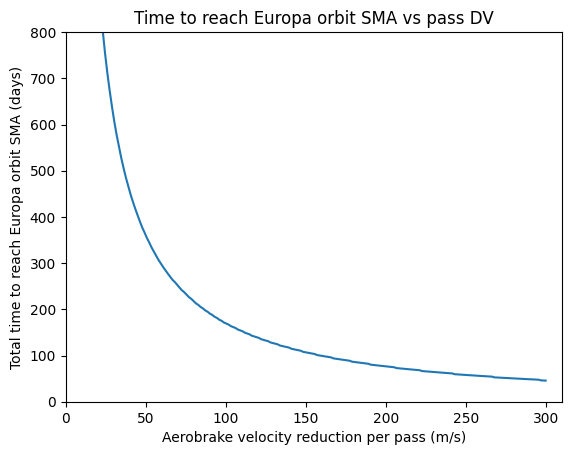

In [91]:
plt.plot(aerobrake_vels,times.to(u.day))
plt.xlabel("Aerobrake velocity reduction per pass (m/s)")
plt.ylabel("Total time to reach Europa orbit SMA (days)")
plt.title("Time to reach Europa orbit SMA vs pass DV")

plt.xlim(0,310)
plt.ylim(0,800)

(0.0, 90.0)

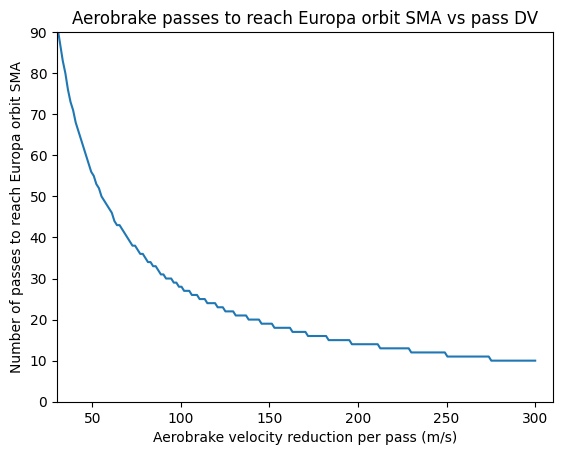

In [ ]:
plt.plot(aerobrake_vels,iterations)
plt.xlabel("Aerobrake velocity reduction per pass (m/s)")
plt.ylabel("Number of orbits to reach Europa orbit SMA")
plt.title("Aerobrake passes to reach Europa orbit SMA vs pass DV")
plt.xlim(30,310)
plt.ylim(0,90)